In [1]:
COLAB_MODELS_ID = '10YVPo5m0AzOwGLkwaYVbxdE3RZFHVNm9'
PATH_METRICS = 'metrics_ensemble'
MODEL_NAME_FORMAT = lambda i: f'model{i+1}.pt'
ARCHIVE_NAME = 'scheduler.zip'

PATH_CIFAR10_MODELS = 'scheduler/cifar10/'
ENSEMBLE_SIZE_CIFAR10 = 30

PATH_CIFAR100_MODELS = 'scheduler/cifar100/'
ENSEMBLE_SIZE_CIFAR100 = 30

In [2]:
!mkdir $PATH_METRICS 
!mkdir plots
!mkdir utils 

## 1. Load data

In [8]:
%%capture
!pip install gdown

In [9]:
# %%capture
!gdown --id $COLAB_MODELS_ID
!unzip $ARCHIVE_NAME
!rm $ARCHIVE_NAME

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10YVPo5m0AzOwGLkwaYVbxdE3RZFHVNm9
To: /kaggle/working/scheduler.zip
100%|███████████████████████████████████████| 5.31G/5.31G [00:23<00:00, 227MB/s]
Archive:  scheduler.zip
   creating: scheduler/
  inflating: __MACOSX/._scheduler    
  inflating: scheduler/.DS_Store     
  inflating: __MACOSX/scheduler/._.DS_Store  
   creating: scheduler/cifar100/
  inflating: __MACOSX/scheduler/._cifar100  
   creating: scheduler/cifar10/
  inflating: __MACOSX/scheduler/._cifar10  
  inflating: scheduler/cifar100/model1.pt  
  inflating: __MACOSX/scheduler/cifar100/._model1.pt  
  inflating: scheduler/cifar100/model5.pt  
  inflating: __MACOSX/scheduler/cifar100/._model5.pt  
  inflating: scheduler/cifar100/model4.pt  
  inflati

## 2. Import dependencies

In [10]:
import os
from tqdm import tqdm
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.model
%aimport utils.attacks
%aimport utils.uncertainty_baselines
%aimport utils.adversarial_radius

## 3. Prepare dataloaders

In [11]:
_, (train_loader_10, test_loader_10) = utils.data.get_train_test_dataloaders(
            dataset_type='cifar10',
            root_data_folder='./data',
            batch_size=64
            )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


In [12]:
_, (train_loader_100, test_loader_100) = utils.data.get_train_test_dataloaders(
            dataset_type='cifar100',
            root_data_folder='./data',
            batch_size=64
            )

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar100/cifar-100-python.tar.gz to ./data/cifar100
Files already downloaded and verified


## 4. Tests
### 4.1 CIFAR10

#### Load models of ensemble

In [13]:
PATH_METRICS_CIFAR10 = PATH_METRICS + '/cifar10'
!mkdir $PATH_METRICS_CIFAR10

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#base model
model_10 = torchvision.models.resnet50(pretrained=False)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10 = model_10.to(device)

In [15]:
#get models of ensemble
model_list_10 = []
for i in range(ENSEMBLE_SIZE_CIFAR10):
    model = copy.deepcopy(model_10)
    model.load_state_dict(torch.load(PATH_CIFAR10_MODELS + MODEL_NAME_FORMAT(i), map_location=device))
    model_list_10.append(model)

#### Get baseline metrics

In [16]:
utils.uncertainty_baselines.uncertainty_estimation_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    n_of_classes=10,
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/uncertainty_baselines.npz',
    device=device
)

100%|██████████| 157/157 [01:08<00:00,  2.30it/s]


#### Get adversarial radii metrics

In [17]:
#mean radii, l2 norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=100,
    tol=1e-5,
    step_size=0.5,
    device=device,
    norm='l2',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/adversarial_radii_mean_l2.npz'
)

100%|██████████| 157/157 [03:53<00:00,  1.49s/it]


In [18]:
#mean radii, inf norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=100,
    tol=1e-5,
    step_size=0.1,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/adversarial_radii_mean_inf.npz'
)

100%|██████████| 157/157 [03:53<00:00,  1.49s/it]


In [19]:
# utils.adversarial_radius.get_step_radii_on_ensemble(
#     model_list=model_list_10,
#     loader=test_loader_10,
#     image_diap=(-2.42906574, 2.75373134),
#     loss=nn.CrossEntropyLoss(),
#     eps=0.01,
#     max_steps=100,
#     device=device,
#     norm='l2',
#     save=True,
#     path2save=PATH_METRICS_CIFAR10+'/step_radii_mean_l2.npz'
# )

In [20]:
utils.adversarial_radius.get_step_radii_on_ensemble(
    model_list=model_list_10,
    loader=test_loader_10,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    eps=0.005,
    max_steps=1000,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR10+'/step_radii_mean_inf.npz'
)

100%|██████████| 157/157 [02:53<00:00,  1.10s/it]


#### Get rejection curves for baselines

In [21]:
baselines = np.load(PATH_METRICS_CIFAR10+'/uncertainty_baselines.npz')
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_ensemble_cifar10 = {}
metrics_10 = {}

#Calculate values of accuracy for each rejection rate based on baseline uncertainty metrics
for uncertainty_proxy in ['predicted_entropy',
                          'expected_entropy',
                          'mutual_information',
                          'std_probas_modal_class',
                          'std_probas_mean',
                          'maxprobs']:
    rejection_curves_ensemble_cifar10[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=baselines[uncertainty_proxy],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_10[' '.join(uncertainty_proxy.split('_'))] = baselines[uncertainty_proxy]
    
#Calculate values of absolute confidence curve
rejection_curves_ensemble_cifar10['absolute confidence'] = utils.uncertainty_baselines.get_best_vals_for_plot(
    baselines['preds'], 
    baselines['targets'],
    rejection_rates[:-1])

#Calculate values of accuracy for each rejection rate based on random uncertainty metrics
np.random.seed(40)
random_proxy = np.random.uniform(size=len(baselines['targets']))
rejection_curves_ensemble_cifar10['random uncertainty'] = utils.uncertainty_baselines.reject_by_metric(
    uncertainty_proxy=random_proxy,
    preds=baselines['preds'],
    labels=baselines['targets'],
    rejection_rates=rejection_rates,
    scoring_func=accuracy_score)

#### Get rejection curves for adversarial radii and step radii

In [22]:
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_radii_ensemble_cifar10 = {}

#adversarial radii
adversarial_radii_mean_l2_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/adversarial_radii_mean_l2.npz')
adversarial_radii_mean_inf_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/adversarial_radii_mean_inf.npz')

radii_metrics = [adversarial_radii_mean_l2_cifar10_ensemble,
                 adversarial_radii_mean_inf_cifar10_ensemble]

radii_metrics_names = ['mean adv.rad, l2-norm',
                       'mean adv.rad, inf-norm']

for uncertainty_proxy, radii_metric in zip(radii_metrics_names, radii_metrics):
    rejection_curves_radii_ensemble_cifar10[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-radii_metric['mean_adversarial_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_10[uncertainty_proxy] = -radii_metric['mean_adversarial_radii']
    
#step radii
# step_radii_mean_l2_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/step_radii_mean_l2.npz')
step_radii_mean_inf_cifar10_ensemble = np.load(PATH_METRICS_CIFAR10+'/step_radii_mean_inf.npz')

step_metrics = [
#                 step_radii_mean_l2_cifar10_ensemble, 
                step_radii_mean_inf_cifar10_ensemble]

step_metrics_names = [
#                       'mean step rad. l2-norm',
                      'mean step rad. inf-norm']

for uncertainty_proxy, step_metric in zip(step_metrics_names, step_metrics):
    rejection_curves_radii_ensemble_cifar10[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-step_metric['mean_step_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_10[uncertainty_proxy] = -step_metric['mean_step_radii']

In [23]:
del model_10
del model_list_10

### 4.2 CIFAR100

#### Load models of ensemble

In [24]:
PATH_METRICS_CIFAR100 = PATH_METRICS + '/cifar100'
!mkdir $PATH_METRICS_CIFAR100

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#base model
model_100 = torchvision.models.resnet50(pretrained=False)
model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
model_100 = model_100.to(device)

In [26]:
#get models of ensemble
model_list_100 = []
for i in range(ENSEMBLE_SIZE_CIFAR100):
    model = copy.deepcopy(model_100)
    model.load_state_dict(torch.load(PATH_CIFAR100_MODELS + MODEL_NAME_FORMAT(i), map_location=device))
    model_list_100.append(model)

#### Get baseline metrics

In [27]:
utils.uncertainty_baselines.uncertainty_estimation_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    n_of_classes=100,
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/uncertainty_baselines.npz',
    device=device
)

100%|██████████| 157/157 [01:03<00:00,  2.49it/s]


#### Get adversarial radii metrics

In [28]:
#mean radii, l2 norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=100,
    tol=1e-5,
    step_size=0.5,
    device=device,
    norm='l2',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/adversarial_radii_mean_l2.npz'
)

100%|██████████| 157/157 [03:55<00:00,  1.50s/it]


In [29]:
#mean radii, inf norm

utils.adversarial_radius.get_adversarial_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    max_steps=100,
    tol=1e-5,
    step_size=0.1,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/adversarial_radii_mean_inf.npz'
)

100%|██████████| 157/157 [03:51<00:00,  1.48s/it]


In [30]:
# utils.adversarial_radius.get_step_radii_on_ensemble(
#     model_list=model_list_100,
#     loader=test_loader_100,
#     image_diap=(-2.42906574, 2.75373134),
#     loss=nn.CrossEntropyLoss(),
#     eps=0.01,
#     max_steps=100,
#     device=device,
#     norm='l2',
#     save=True,
#     path2save=PATH_METRICS_CIFAR100+'/step_radii_mean_l2.npz'
# )

In [31]:
utils.adversarial_radius.get_step_radii_on_ensemble(
    model_list=model_list_100,
    loader=test_loader_100,
    image_diap=(-2.42906574, 2.75373134),
    loss=nn.CrossEntropyLoss(),
    eps=0.005,
    max_steps=1000,
    device=device,
    norm='inf',
    save=True,
    path2save=PATH_METRICS_CIFAR100+'/step_radii_mean_inf.npz'
)

100%|██████████| 157/157 [02:10<00:00,  1.20it/s]


#### Get rejection curves for baselines

In [32]:
baselines = np.load(PATH_METRICS_CIFAR100+'/uncertainty_baselines.npz')
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_ensemble_cifar100 = {}
metrics_100 = {}

#Calculate values of accuracy for each rejection rate based on baseline uncertainty metrics
for uncertainty_proxy in ['predicted_entropy',
                          'expected_entropy',
                          'mutual_information',
                          'std_probas_modal_class',
                          'std_probas_mean',
                          'maxprobs']:
    rejection_curves_ensemble_cifar100[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=baselines[uncertainty_proxy],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_100[' '.join(uncertainty_proxy.split('_'))] = baselines[uncertainty_proxy]
    
#Calculate values of absolute confidence curve
rejection_curves_ensemble_cifar100['absolute confidence'] = utils.uncertainty_baselines.get_best_vals_for_plot(
    baselines['preds'], 
    baselines['targets'],
    rejection_rates[:-1])

#Calculate values of accuracy for each rejection rate based on random uncertainty metrics
np.random.seed(40)
random_proxy = np.random.uniform(size=len(baselines['targets']))
rejection_curves_ensemble_cifar100['random uncertainty'] = utils.uncertainty_baselines.reject_by_metric(
    uncertainty_proxy=random_proxy,
    preds=baselines['preds'],
    labels=baselines['targets'],
    rejection_rates=rejection_rates,
    scoring_func=accuracy_score)

#### Get rejection curves for adversarial radii and step radii

In [33]:
rejection_rates = np.linspace(0, 1, 1000)
rejection_curves_radii_ensemble_cifar100 = {}

#adversarial radii
adversarial_radii_mean_l2_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/adversarial_radii_mean_l2.npz')
adversarial_radii_mean_inf_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/adversarial_radii_mean_inf.npz')

radii_metrics = [adversarial_radii_mean_l2_cifar100_ensemble,
                 adversarial_radii_mean_inf_cifar100_ensemble]

radii_metrics_names = ['mean adv.rad, l2-norm',
                       'mean adv.rad, inf-norm']

for uncertainty_proxy, radii_metric in zip(radii_metrics_names, radii_metrics):
    rejection_curves_radii_ensemble_cifar100[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-radii_metric['mean_adversarial_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_100[uncertainty_proxy] = -radii_metric['mean_adversarial_radii']
    
#step radii
# step_radii_mean_l2_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/step_radii_mean_l2.npz')
step_radii_mean_inf_cifar100_ensemble = np.load(PATH_METRICS_CIFAR100+'/step_radii_mean_inf.npz')

step_metrics = [
#                 step_radii_mean_l2_cifar100_ensemble, 
                step_radii_mean_inf_cifar100_ensemble]

step_metrics_names = [
#                       'mean step rad. l2-norm',
                      'mean step rad. inf-norm']

for uncertainty_proxy, step_metric in zip(step_metrics_names, step_metrics):
    rejection_curves_radii_ensemble_cifar100[uncertainty_proxy] = utils.uncertainty_baselines.reject_by_metric(
        uncertainty_proxy=-step_metric['mean_step_radii'],
        preds=baselines['preds'],
        labels=baselines['targets'],
        rejection_rates=rejection_rates,
        scoring_func=accuracy_score)
    metrics_100[uncertainty_proxy] = -step_metric['mean_step_radii']

In [34]:
del model_100
del model_list_100

#### Visualize rejection curves

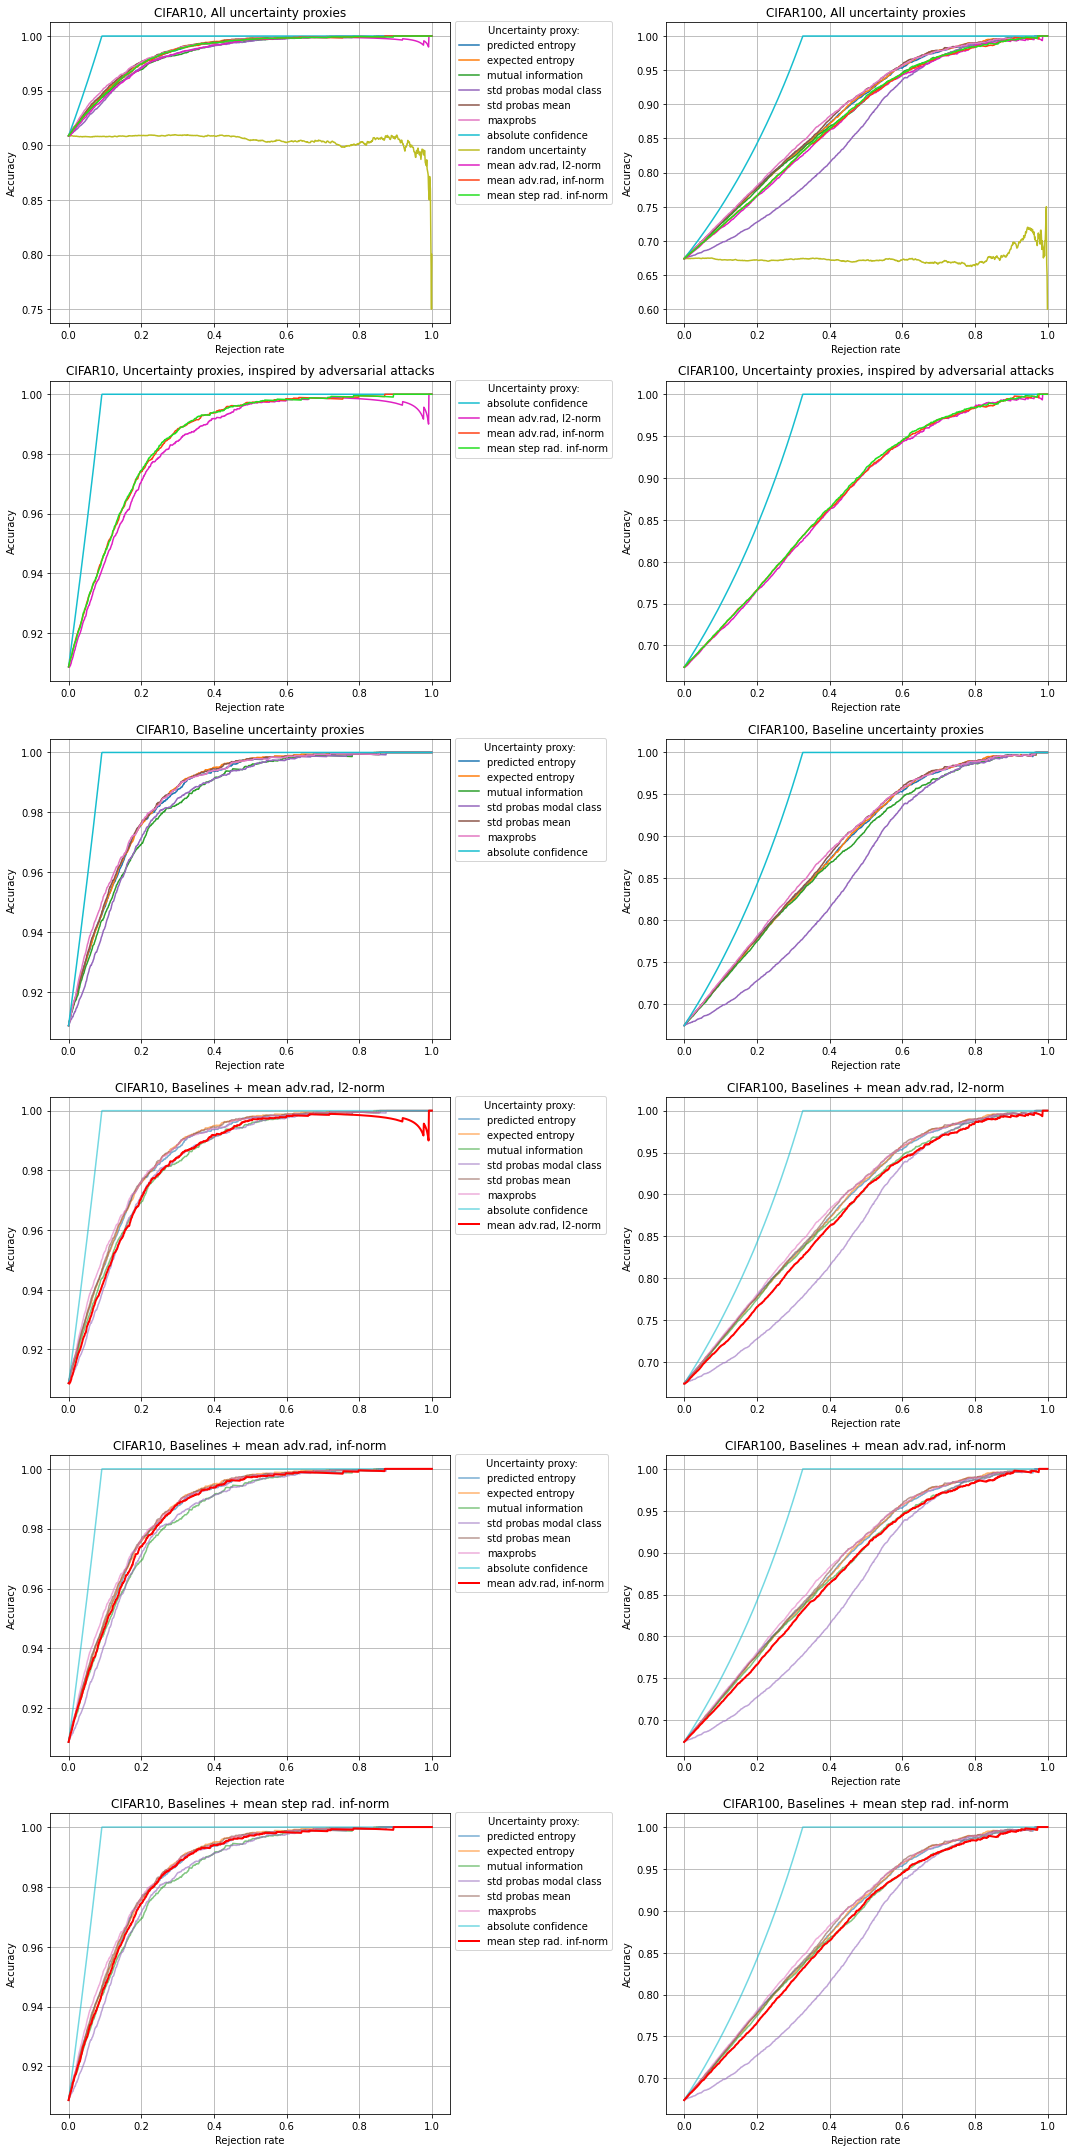

In [35]:
radii_proxy_names = list(rejection_curves_radii_ensemble_cifar10.keys())
colors = dict(zip(rejection_curves_ensemble_cifar10.keys(),
         ['tab:blue','tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'tab:olive']))
colors_radii = dict(zip(rejection_curves_radii_ensemble_cifar10.keys(),
         ['#df20c2','#ff3f14', '#23df20', '#184e49', '#204ddf']))

titles = ['All uncertainty proxies', 'Uncertainty proxies, inspired by adversarial attacks',
         'Baseline uncertainty proxies', 'Baselines + mean adv.rad, l2-norm', 'Baselines + mean adv.rad, inf-norm',
         'Baselines + mean step rad. inf-norm']
fig, ax = plt.subplots(6, 2, figsize=(15, 30))

#CIFAR10
for i in range(6):
    for uncertainty_proxy in rejection_curves_ensemble_cifar10.keys():
        label = ' '.join(uncertainty_proxy.split('_'))
        if i == 0:
            ax[i][0].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar10[uncertainty_proxy],
                          label=label, c=colors[uncertainty_proxy])
        if (i > 1 and (uncertainty_proxy != 'random uncertainty')):
            ax[i][0].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar10[uncertainty_proxy],
                              label=label, alpha=0.6 if i!=2 else 1, c=colors[uncertainty_proxy])
    if i == 1:
        ax[i][0].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar10['absolute confidence'],
                      label='absolute confidence', c=colors['absolute confidence'])
    if i in (0, 1):
        for uncertainty_proxy in rejection_curves_radii_ensemble_cifar10.keys():
            ax[i][0].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar10[uncertainty_proxy],
                          label=' '.join(uncertainty_proxy.split('_')), c=colors_radii[uncertainty_proxy])
    elif i > 2:
        ax[i][0].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar10[radii_proxy_names[i-3]],
                      label=radii_proxy_names[i-3], color='red', lw=2.0)
    
    ax[i][0].set_title('CIFAR10, '+titles[i])
    ax[i][0].set_xlabel('Rejection rate')
    ax[i][0].set_ylabel('Accuracy')
    ax[i][0].grid(visible=True)
    ax[i][0].legend(title='Uncertainty proxy:', bbox_to_anchor=(1, 1.02))
    
#CIFAR100 
for i in range(6):
    for uncertainty_proxy in rejection_curves_ensemble_cifar100.keys():
        label = ' '.join(uncertainty_proxy.split('_'))
        if i == 0:
            ax[i][1].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar100[uncertainty_proxy],
                          label=label, c=colors[uncertainty_proxy])
        if (i > 1 and (uncertainty_proxy != 'random uncertainty')):
            ax[i][1].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar100[uncertainty_proxy],
                              label=label, alpha=0.6 if i!=2 else 1, c=colors[uncertainty_proxy])
    if i == 1:
        ax[i][1].plot(rejection_rates[:-1], rejection_curves_ensemble_cifar100['absolute confidence'],
                      label='absolute confidence', c=colors['absolute confidence'])
    if i in (0, 1):
        for uncertainty_proxy in rejection_curves_radii_ensemble_cifar100.keys():
            ax[i][1].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar100[uncertainty_proxy],
                          label=' '.join(uncertainty_proxy.split('_')), c=colors_radii[uncertainty_proxy])
    elif i > 2:
        ax[i][1].plot(rejection_rates[:-1], rejection_curves_radii_ensemble_cifar100[radii_proxy_names[i-3]],
                      label=radii_proxy_names[i-3], color='red', lw=2.0)
    
    ax[i][1].set_title('CIFAR100, '+titles[i])
    ax[i][1].set_xlabel('Rejection rate')
    ax[i][1].set_ylabel('Accuracy')
    ax[i][1].grid(visible=True)
#     ax[i][1].legend(title='Uncertainty proxy:')

plt.tight_layout()
fig.savefig('plots/rejection_curves.pdf', bbox_inches='tight')

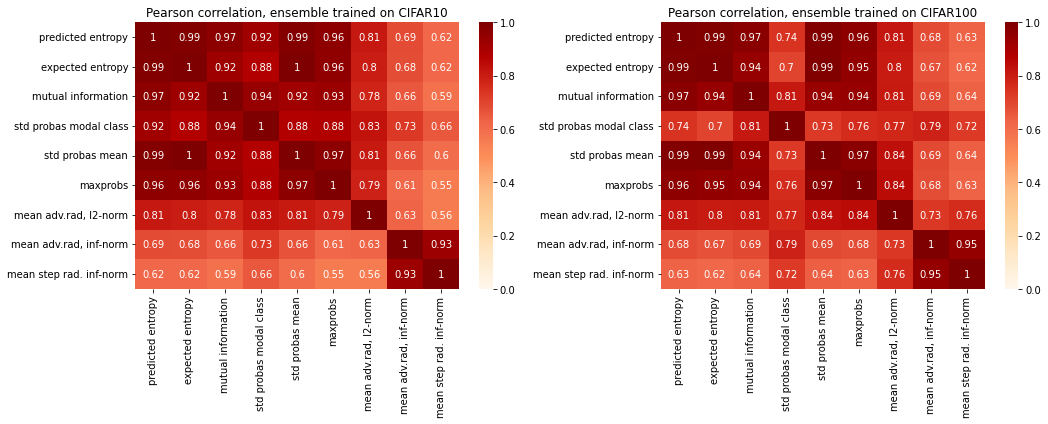

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(pd.DataFrame(metrics_10).corr(method='pearson'), annot=True, vmin=0, vmax=1, ax=ax[0], cmap='OrRd')
ax[0].set_title('Pearson correlation, ensemble trained on CIFAR10')
sns.heatmap(pd.DataFrame(metrics_100).corr(method='pearson'), annot=True, vmin=0, vmax=1, ax=ax[1], cmap='OrRd')
ax[1].set_title('Pearson correlation, ensemble trained on CIFAR100')
plt.tight_layout()
fig.savefig('plots/pearson_correlations.pdf', bbox_inches='tight')

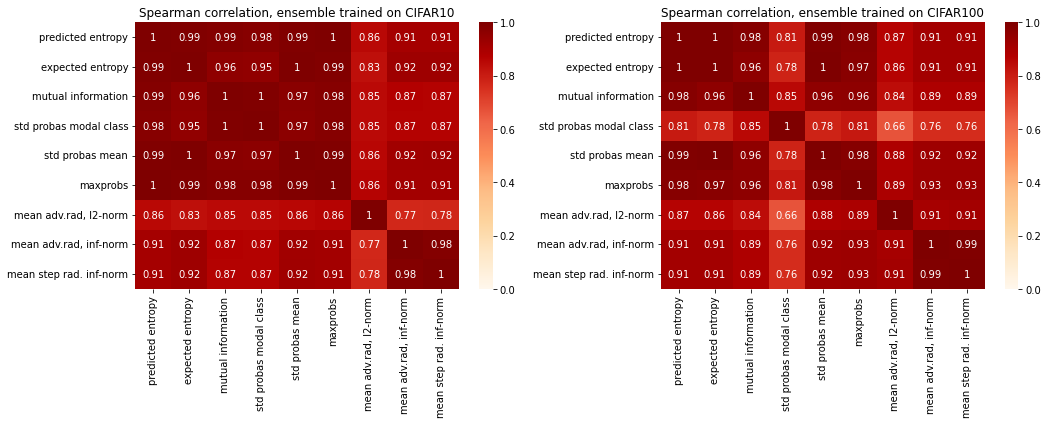

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(pd.DataFrame(metrics_10).corr(method='spearman'), annot=True, vmin=0, vmax=1, ax=ax[0], cmap='OrRd')
ax[0].set_title('Spearman correlation, ensemble trained on CIFAR10')
sns.heatmap(pd.DataFrame(metrics_100).corr(method='spearman'), annot=True, vmin=0, vmax=1, ax=ax[1], cmap='OrRd')
ax[1].set_title('Spearman correlation, ensemble trained on CIFAR100')
plt.tight_layout()
fig.savefig('plots/spearman_correlations.pdf', bbox_inches='tight')